In [2]:
%pylab inline
import pandas as pd
import fastparquet 
import os,sys

Populating the interactive namespace from numpy and matplotlib


In [3]:
import lightgbm as lgb

In [4]:
if 0:
    sys.path.insert(0,os.getcwd()+"/../../src/main")
else:
    sys.path.insert(0, "/mnt/lanlep2019/src/main")
    os.environ['LOCAL']="/mnt/local"

In [5]:
!echo $LOCAL

/mnt/local


In [6]:
!mkdir -p $LOCAL/sandbox

In [7]:
HOME=os.environ['LOCAL']+"/sandbox"
os.chdir(HOME)
os.getcwd()

'/mnt/local/sandbox'

In [8]:
os.environ['LANLEP_HOME']=HOME

In [9]:
import data

In [10]:
if 0:
    !ls /home/lizhen09/lanlep2019/input/feat/*.parq | grep -v offset_.parq | xargs -L1  -IINPUT cp INPUT {HOME}/input/feat/
else:
    !cd {HOME}/input/feat/ && cat /mnt/lizhen-east2/notebook/fastseq/5/tmp.tar | tar xf - 
    !cd {HOME}/input/feat/ && cat /mnt/lizhen-east2/notebook/fastseq/5/tmppkl.tar | tar xf -     

In [13]:
reload (data)

<module 'data' from '/mnt/lanlep2019/src/main/data.py'>

In [14]:
if 1:
    strategy = {'type':'rand', "fold":5}
    types=['fwv']
    traintest = data.TrainTest('offset', offset=0, types=types, transform=None, valid_strategy=strategy)

In [15]:
traintest.num_dataset()

5

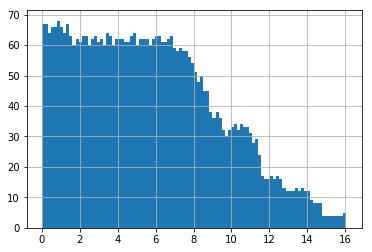

In [16]:
traintest.ydf.hist(bins=100);

In [19]:
np.abs(traintest.ydf-traintest.ydf.median()).mean(),np.median(traintest.ydf)

(3.032763197384022, 5.340797185897827)

In [20]:
testdf=traintest.get_test_data()
testdf.shape

(2624, 100)

In [21]:
datadf=pd.concat([traintest.traindf, traintest.ydf],axis=1)
print datadf.shape
datadf.head()

(4184, 101)


fwv_0     fwv_1     fwv_2     fwv_3     fwv_4     fwv_5  \
index                                                                       
quake_07_0405  0.177243  0.148722  0.101298 -0.151453  0.118340  0.085533   
quake_07_0404  0.175916  0.208865  0.121425 -0.149945  0.078927 -0.033455   
quake_07_0159  0.123625  0.259964  0.114662 -0.177983  0.076714 -0.008650   
quake_07_0158  0.127892  0.236912  0.120239 -0.147701  0.065033 -0.029501   
quake_07_0401  0.168152  0.240921  0.146662 -0.184900  0.126381  0.005611   

                  fwv_6     fwv_7     fwv_8     fwv_9    ...       fwv_91  \
index                                                    ...                
quake_07_0405 -0.126488  0.383367  0.184891 -0.182000    ...     0.276661   
quake_07_0404 -0.001732  0.259981  0.170118 -0.146734    ...     0.182124   
quake_07_0159  0.029887  0.234569  0.166675 -0.139920    ...     0.131131   
quake_07_0158  0.007605  0.238272  0.166551 -0.104213    ...     0.158076   
quake_07_0401  0.008869  0.288528  0.169460 -0.190870    ...     0.173906   

                 fwv_92    fwv_93    fwv_94    fwv_95    fwv_96    fwv_97  \
index                                                                       
quake_07_0405 -0.040588 -0.079376 -0.185854  0.031153  0.011661 -0.177359   
quake_07_0404  0.020085  0.007380 -0.045135  0.012951  0.022898 -0.136806   
quake_07_0159  0.068873  0.045272  0.115157  0.038833  0.072388 -0.109722   
quake_07_0158  0.011800  0.050090  0.066010  0.055765  0.051091 -0.113880   
quake_07_0401  0.000818  0.020374 -0.018780  0.006945  0.040418 -0.139294   

                 fwv_98    fwv_99         y  
index                                        
quake_07_0405  0.021507  0.143021  0.287999  
quake_07_0404  0.015471  0.179152  0.327298  
quake_07_0159 -0.035507  0.092227  9.873498  
quake_07_0158  0.000226  0.118060  9.912896  
quake_07_0401 -0.030202  0.189248  0.444397  

[5 rows x 101 columns]

In [22]:
datadf= datadf[~datadf.index.duplicated(keep='first')]
datadf.shape

(4184, 101)

In [23]:
ydf=traintest.ydf
ydf.head()

index
quake_07_0405    0.287999
quake_07_0404    0.327298
quake_07_0159    9.873498
quake_07_0158    9.912896
quake_07_0401    0.444397
Name: y, dtype: float64

In [24]:
qdf=pd.DataFrame(datadf.index.map(lambda u: u.split("_")[1]).astype(np.int8),index=datadf.index)
qdf.head()

index
index               
quake_07_0405      7
quake_07_0404      7
quake_07_0159      7
quake_07_0158      7
quake_07_0401      7

In [25]:
qdf=qdf[~qdf['index'].isin({0,16})]
datadf=datadf.loc[qdf.index]
ydf=datadf['y']
datadf=datadf.drop('y',axis=1)
qdf.shape,datadf.shape,ydf.shape

((4100, 1), (4100, 100), (4100,))

In [26]:
qdf['index'].value_counts().to_frame().sort_index().T

1    2    3    4    5    6    7    8    9    10   11   12   13   14  \
index  296  363  227  325  206  181  413  202  247  293  282  226  219  378   

        15  
index  242

In [27]:
qlen=qdf['index'].value_counts().to_dict()
str(qlen)

'{1: 296, 2: 363, 3: 227, 4: 325, 5: 206, 6: 181, 7: 413, 8: 202, 9: 247, 10: 293, 11: 282, 12: 226, 13: 219, 14: 378, 15: 242}'

In [28]:
quakes=set(qdf['index'])
quakes

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}

In [29]:
import utils
n_thread= utils.get_num_thread()
n_thread

15

In [55]:
def train_quake(qno,params,n_thread, nround):
    assert(qno in quakes)
    print 'valid quake', qno
    teidx=qdf['index']==qno
    tridx=~teidx
    
    Xtr,ytr,Xte,yte=datadf[tridx],ydf[tridx],datadf[teidx],ydf[teidx],
    Xtr,ytr,Xte,yte=[u.values for u in [Xtr,ytr,Xte,yte]]
    print Xtr.shape,ytr.shape,Xte.shape,yte.shape
    model = lgb.LGBMRegressor(n_estimators = nround, n_jobs = n_thread, **params)
    model.fit(Xtr, ytr, 
                    eval_set=[(Xtr, ytr), (Xte, yte)], eval_metric='mae',
                    verbose=50, early_stopping_rounds=None)
    #print dir (model)
    #print model.evals_result_
    #return model.best_score_['valid_1']['l1'], model.best_iteration_
    return model.evals_result_['valid_1']['l1']

In [56]:
params = {'num_leaves': 54,
          #'min_data_in_leaf': 79,
          'objective': 'huber',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501
         }

In [58]:
validScores={}

In [ ]:
for nround in [10000]:
    if nround not in validScores:
        #scores={}
        for qno in quakes:
            s=train_quake(qno,params,n_thread,nround)
            print "quake ", qno,s
            validScores[qno]=s
        #validScores[nround]=scores

In [62]:
vdf =pd.DataFrame(validScores)

In [73]:
np.argmin(vdf.mean(1)),np.argmin(vdf.median(1)),np.min(vdf.mean(1)),np.min(vdf.median(1))

(584, 912, 2.096503571857796, 1.8327318707358673)

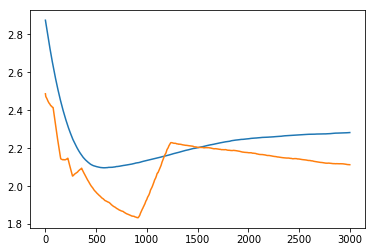

In [71]:
vdf.mean(1)[:3000].plot()
vdf.median(1)[:3000].plot()

In [86]:
vdf.head()

1         2         3         4         5         6         7   \
0  2.880953  3.707839  2.402332  3.206294  2.373208  2.475824  4.457504   
1  2.877353  3.705066  2.397750  3.202675  2.370518  2.474866  4.455185   
2  2.873756  3.702289  2.392841  3.199072  2.367931  2.473906  4.452856   
3  2.870379  3.699527  2.387950  3.195570  2.365152  2.472906  4.450528   
4  2.866668  3.696798  2.383076  3.192256  2.362464  2.471952  4.448221   

         8         9         10        11        12        13        14  \
0  2.374992  2.486746  2.850292  2.744466  2.396404  2.377543  3.920801   
1  2.372740  2.482008  2.846305  2.739667  2.391921  2.373529  3.918480   
2  2.370545  2.477290  2.842290  2.734876  2.387241  2.369487  3.916169   
3  2.368384  2.472560  2.838283  2.730147  2.382733  2.365450  3.913962   
4  2.366196  2.467859  2.834334  2.725431  2.378186  2.361403  3.911767   

         15  
0  2.457541  
1  2.453662  
2  2.449798  
3  2.445282  
4  2.441426

In [89]:
#vdf.to_csv("/mnt/lizhen-east2/notebook/fastseq/5/dataoffset_qfold_noearly.csv",index=None)

In [76]:
testpred=[]
for qno in quakes:
    print 'valid quake', qno
    teidx=qdf['index']==qno
    tridx=~teidx
    
    Xtr,ytr,Xte,yte=datadf[tridx],ydf[tridx],datadf[teidx],ydf[teidx],
    Xtr,ytr,Xte,yte=[u.values for u in [Xtr,ytr,Xte,yte]]
    print Xtr.shape,ytr.shape,Xte.shape,yte.shape

    
    model = lgb.LGBMRegressor(n_estimators = 1000, n_jobs = n_thread, **params)
    model.fit(Xtr, ytr, 
                    eval_set=[(Xtr, ytr), (Xte, yte)], eval_metric='mae',
                    verbose=50, early_stopping_rounds=None)
    #584, 912
    a = model.predict(testdf.values,  num_iteration=584)
    b = model.predict(testdf.values,  num_iteration=912)
    testpred.append([a,b])

valid quake 1
(3804, 100) (3804,) (296, 100) (296,)
[50]	training's l1: 2.79458	valid_1's l1: 2.70427
[100]	training's l1: 2.59759	valid_1's l1: 2.55689
[150]	training's l1: 2.42191	valid_1's l1: 2.43222
[200]	training's l1: 2.26595	valid_1's l1: 2.32668
[250]	training's l1: 2.12922	valid_1's l1: 2.23682
[300]	training's l1: 2.00936	valid_1's l1: 2.16356
[350]	training's l1: 1.90664	valid_1's l1: 2.10543
[400]	training's l1: 1.81937	valid_1's l1: 2.0486
[450]	training's l1: 1.74514	valid_1's l1: 2.00238
[500]	training's l1: 1.6798	valid_1's l1: 1.96837
[550]	training's l1: 1.62258	valid_1's l1: 1.94085
[600]	training's l1: 1.57111	valid_1's l1: 1.92101
[650]	training's l1: 1.52291	valid_1's l1: 1.90293
[700]	training's l1: 1.47805	valid_1's l1: 1.88474
[750]	training's l1: 1.4351	valid_1's l1: 1.86953
[800]	training's l1: 1.39464	valid_1's l1: 1.85496
[850]	training's l1: 1.35562	valid_1's l1: 1.84348
[900]	training's l1: 1.3191	valid_1's l1: 1.83503
[950]	training's l1: 1.28338	valid_

[750]	training's l1: 1.4193	valid_1's l1: 2.37531
[800]	training's l1: 1.3771	valid_1's l1: 2.39095
[850]	training's l1: 1.33757	valid_1's l1: 2.40064
[900]	training's l1: 1.29951	valid_1's l1: 2.4117
[950]	training's l1: 1.26341	valid_1's l1: 2.42859
[1000]	training's l1: 1.22952	valid_1's l1: 2.44341
valid quake 9
(3853, 100) (3853,) (247, 100) (247,)
[50]	training's l1: 2.82818	valid_1's l1: 2.25149
[100]	training's l1: 2.63675	valid_1's l1: 2.03501
[150]	training's l1: 2.46628	valid_1's l1: 1.83663
[200]	training's l1: 2.31594	valid_1's l1: 1.66385
[250]	training's l1: 2.18254	valid_1's l1: 1.51968
[300]	training's l1: 2.06568	valid_1's l1: 1.39671
[350]	training's l1: 1.96407	valid_1's l1: 1.292
[400]	training's l1: 1.8746	valid_1's l1: 1.22055
[450]	training's l1: 1.79884	valid_1's l1: 1.16685
[500]	training's l1: 1.73148	valid_1's l1: 1.1294
[550]	training's l1: 1.67035	valid_1's l1: 1.09995
[600]	training's l1: 1.61448	valid_1's l1: 1.07842
[650]	training's l1: 1.56312	valid_1'

5.513077160807719 5.192557201366257


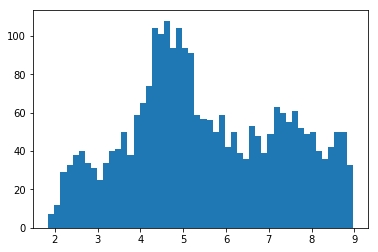

In [80]:
pred = reduce(lambda u,v: u+v, [x[0] for x in testpred])/len(testpred)
print np.mean(pred),np.median(pred)
plt.hist(pred,bins=50);

In [81]:
a=pd.DataFrame(pred,index=testdf.index).reset_index()
a.columns=["seg_id","time_to_failure"]
print a.shape
a.to_csv(os.environ['LOCAL']+"/input/sub/test_fwv_nonovp_qfold_lgb_n584mean.csv",index=None)

(2624, 2)


5.5130269201737905 5.224602200689722


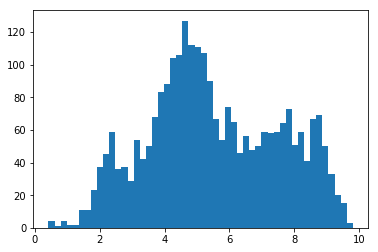

In [82]:
pred = np.median(np.array([x[1] for x in testpred]).T,1)
print np.mean(pred),np.median(pred)
plt.hist(pred,bins=50);

In [84]:
a=pd.DataFrame(pred,index=testdf.index).reset_index()
a.columns=["seg_id","time_to_failure"]
print a.shape
a.to_csv(os.environ['LOCAL']+"/input/sub/test_fwv_nonovp_qfold_lgb_n912median.csv",index=None)

(2624, 2)
